In [1]:
from autots import AutoTS,model_forecast
from autots.datasets import load_hourly
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from autots import load_daily, model_forecast

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [11]:
def update_excel_intensities(filename,df,sheet,mode='a'):
    if mode=='a':
        with pd.ExcelWriter(filename,mode=mode, if_sheet_exists='replace') as writer:  
            df.to_excel(writer, sheet_name=sheet)
    else:
        with pd.ExcelWriter(filename,mode=mode) as writer:  
            df.to_excel(writer, sheet_name=sheet)
    
def read_excel_sheet(file,sheetname):
    customers = pd.read_excel(file,
        sheet_name=sheetname,
        header=0,
        index_col=0,
        keep_default_na=True
        )
    return customers

def read_csv(file,sheetname):
    customers = pd.read_csv(file,
        header=0,
        sep=';',
        index_col=0,
        keep_default_na=True
        )
    
    customers.fillna(0,inplace=True)
    
    return customers

def div100(x):
    return x/100.0

def mul100(x):
    return x*100.0

def logistic(x):
    return np.log(x/(1-x))

def invlogistic(x):
    return np.exp(x)/(1+np.exp(x))

def onex(x):
    return x/(1-x)

def invonex(x):
    return x/(1+x)

def onex2(x):
    return x*x/(1-x*x)

def invonex2(x):
    return np.sqrt(x/(1+x))

In [35]:
#data = read_excel_sheet('data/predictions_backtesting_2023.xlsx','2022')
data = read_excel_sheet('data/testdata.xlsx','2022')
data=data[data.index<2024]#iloc[:10,:]


In [36]:
#data=data.reset_index(drop=True)
#data.index2 = data.index
#display(data.index)
#for k,v in enumerate(x):
#    data.loc[str(v),'index2'] = str(v)
#data=data.set_index(data.index2,inplace=True)
data.index = pd.to_datetime(data.index,format='%Y')
display(data)


alypuhelin  some_25_34  some_35_44  avioituvuus_25_29  \
vuosi                                                               
1989-01-01         0.0    0.000000    0.000000          88.300000   
1990-01-01         0.0    0.000000    0.000000          87.500000   
1991-01-01         0.0    0.000000    0.000000          86.000000   
1992-01-01         0.0    0.000000    0.000000          81.100000   
1993-01-01         0.0    0.000000    0.000000          84.800000   
1994-01-01         0.0    0.000000    0.000000          84.100000   
1995-01-01         0.0    0.000000    0.000000          78.500000   
1996-01-01         0.0    0.000000    0.000000          78.500000   
1997-01-01         0.0    0.000000    0.000000          75.500000   
1998-01-01         0.0    0.000000    0.000000          74.800000   
1999-01-01         0.0    0.000000    0.000000          74.400000   
2000-01-01         0.0    0.100625    0.056875          76.900000   
2001-01-01         0.0    0.201250    0.113750          72.700000   
2002-01-01         0.0    0.402500    0.227500          79.400000   
2003-01-01         0.0    0.805000    0.455000          75.600000   
2004-01-01         0.0    1.610000    0.910000          81.100000   
2005-01-01         0.6    3.220000    1.820000          80.500000   
2006-01-01         1.6    5.060000    2.860000          77.000000   
2007-01-01         3.6    8.280000    4.680000          78.800000   
2008-01-01         6.6   11.500000    6.500000          80.500000   
2009-01-01        11.6   17.480000    9.880000          76.500000   
2010-01-01        18.6   21.160000   11.960000          75.900000   
2011-01-01        28.6   23.000000   13.000000          68.900000   
2012-01-01        38.6   21.000000   13.000000          69.600000   
2013-01-01        51.5   26.000000   18.000000          59.700000   
2014-01-01        61.5   33.000000   19.000000          56.700000   
2015-01-01        68.4   44.000000   27.000000          54.700000   
2016-01-01        74.9   55.000000   41.000000          52.600000   
2017-01-01        79.1   57.000000   41.000000          48.700000   
2018-01-01        80.0   53.000000   47.000000          45.300000   
2019-01-01        83.0   74.000000   73.000000          39.300000   
2020-01-01        87.0   85.000000   79.000000          36.300000   
2021-01-01        88.0   81.000000   72.000000          35.000000   
2022-01-01        88.0   80.000000   76.000000          36.500000   
2023-01-01        88.0   80.000000   76.000000          36.008054   

            avioituvuus_30_34  synnyttajien_keskiika  sisempikaupunki  \
vuosi                                                                   
1989-01-01           49.60000              29.080000            32.50   
1990-01-01           51.40000              29.160071            32.50   
1991-01-01           50.50000              29.170250            32.50   
1992-01-01           49.50000              29.273838            32.30   
1993-01-01           53.60000              29.360658            32.40   
1994-01-01           54.20000              29.504384            32.60   
1995-01-01           52.60000              29.687610            33.00   
1996-01-01           55.40000              29.755130            33.20   
1997-01-01           51.10000              29.852071            33.50   
1998-01-01           52.70000              29.938362            33.70   
1999-01-01           53.00000              29.948293            33.90   
2000-01-01           59.10000              29.930651            34.10   
2001-01-01           55.20000              29.937986            34.30   
2002-01-01           59.70000              29.948762            34.40   
2003-01-01           59.80000              29.999488            34.40   
2004-01-01           69.10000              29.998615            34.40   
2005-01-01           71.80000              29.983955            34.40   
2006-01-01           69.10000              30.016630            34.40  

In [37]:

#df_wide = load_hourly(long=False)
#display(df_wide)

# here we care most about traffic volume, all other series assumed to be weight of 1
weights_hourly = {} #'traffic_volume': 20}

model_list = [
    #'ETS',
    'VECM',
    #'Theta',
    'ARDL',
    #'RollingRegression',
    #'FBProphet',
    'KalmanStateSpace',
    #'WindowRegression',
    #'UnivariateRegression',
    #'PytorchForecasting',
    'LATC',
    #'Constan
]

model = AutoTS(
    forecast_length=10,
    frequency='infer',
    prediction_interval=0.90,
    no_negatives=True,
    ensemble=['all'],
    max_generations=5,
    num_validations=1,
    validation_method='Backwards',
    model_list=model_list,
    transformer_list='all',
    models_to_validate=0.2,
    drop_most_recent=0,
    n_jobs='auto',
)

model = model.fit(
    data
)

prediction = model.predict()
forecasts_df = prediction.forecast
# prediction.long_form_results()


Using 7 cpus for n_jobs.
Data frequency is: AS-JAN, used frequency is: AS-JAN
Model Number: 1 with model VECM in generation 0 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been

Model Number: 5 with model VECM in generation 0 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Adv

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='bfill').fillna(0)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1006: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  self.tile_values_lag_1 = df2.groupby(level=0, axis=0).mean()
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:3804: FutureWarning: DataFrame.fillna with 'method' is de

Model Number: 8 with model LATC in generation 0 of 5
Model Number: 9 with model ARDL in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 9 in generation 0: ARDL
Model Number: 10 with model VECM in generation 0 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Exten

Model Number: 18 with model VECM in generation 0 of 5


/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='bfill').fillna(0)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/window_functions.py:468: RuntimeWarning: invalid va

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Model Number: 19 with model LATC in generation 0 of 5
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 19 in generation 0: LATC
Model Number: 20 with model LATC in generation 0 of 5
Template Eval Error: ValueEr

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:3876: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df - self.lvlshft.reindex(index=df.index, columns=df.columns).fillna(
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:3886: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df + self.lvlshft.reindex(index=df.index, columns=df.columns).fillna(
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:3886: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df + self.lvlshft.reindex(index=df.index, columns=df.columns).fillna(
/Users/anttitanskanen/opt/mi


Model Number: 25 with model KalmanStateSpace in generation 1 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will requir

Model Number: 29 with model VECM in generation 1 of 5


/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - cycles).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1006: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  self.tile_values_lag_1 = df2.groupby(level=0, axis=0).mean()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - cycles).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='bfill').fillna(0)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFra

Template Eval Error: Exception('Transformer AnomalyRemoval failed on fit') in model 35 in generation 1: VECM
Model Number: 36 with model VECM in generation 1 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 36 in generation 1: VECM
Model Number: 37 with model LATC in generation 1 of 5
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 37 in generation 1: LATC
Model Number: 38 with model LATC in generation 1 of 5


/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")


Model Number: 39 with model VECM in generation 1 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Ad

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - cycles).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - cycles).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:888: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.tail(self.window).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/si

Model Number: 42 with model KalmanStateSpace in generation 2 of 5
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 42 in generation 2: KalmanStateSpace
Model Number: 43 with model VECM in generation 2 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Model N

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='bfill').fillna(0)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna w

Model Number: 47 with model VECM in generation 2 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Ad

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/thresholding.py:204: RuntimeWarning: overflow encountered in scalar power
  (1 + mean_perc_decrease) ** self.mean_weight
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/thresholding.py:199: RuntimeWarning: divide by zero encountered in scalar divide
  mean_perc_decr

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:3886: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df + self.lvlshft.reindex(index=df.index, columns=df.columns).fillna(
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - cycles).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - cycles).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/py

Model Number: 53 with model VECM in generation 2 of 5
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 53 in generation 2: VECM
Model Number: 54 with model KalmanStateSpace in generation 2 of 5
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 54 in generation 2: KalmanStateSpace
Model Number: 55 with model VECM in generation 2 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='bfill').fillna(0)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna 

Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 58 in generation 2: KalmanStateSpace
Model Number: 59 with model ARDL in generation 2 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (I

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - cycles).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:3804: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  diff_smoothed = diff_abs.where(diff_mask_0, np.nan).fillna(
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/auto

Model Number: 61 with model KalmanStateSpace in generation 3 of 5
Model Number: 62 with model ARDL in generation 3 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - cycles).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:43: FutureWarni

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='bfill').fillna(0)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:3804: FutureWarning: DataFrame.fillna 

Model Number: 67 with model VECM in generation 3 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Ad

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='bfill').fillna(0)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1004: FutureWarning: The 'axis' keywor

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - cycles).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - cycles).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1006: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  self.tile_values_lag_1 = df2.groupby(level=0, axis=0).mean()
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute

Model Number: 76 with model ARDL in generation 3 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 76 in generation 3: ARDL
Model Number: 77 with model LATC in generation 3 of 5
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 77 in generation 3: LATC
Model Number: 78 with model VECM in generation 3 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled onl

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:3804: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  diff_smoothed = diff_abs.where(diff_mask_0, np.nan).fillna(
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:3817: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group_ids = range_arr[~diff_mask].fillna(method='ffill')  # [diff_mask]
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packa

Model Number: 82 with model VECM in generation 4 of 5
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 82 in generation 4: VECM
Model Number: 83 with model VECM in generation 4 of 5
Template Eval Error: Exception('Transformer AlignLastValue failed on fit') in model 83 in generation 4: VECM
Model Number: 84 with model KalmanStateSpace in generation 4 of 5
Model Number: 85 with model VECM in generation 4 of 5
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 85 in generation 4: VECM
Model Number: 86 with model ARDL in generation 4 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI M

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1006: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  self.tile_values_lag_1 = df2.groupby(level=0, axis=0).mean()
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='bfill').fillna(0)


Model Number: 88 with model ARDL in generation 4 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Adv

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='bfill').fillna(0)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and w

Model Number: 93 with model KalmanStateSpace in generation 4 of 5
Model Number: 94 with model ARDL in generation 4 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:43: FutureWarning: DataFr

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1006: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  self.tile_values_lag_1 = df2.groupby(level=0, axis=0).mean()
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1004: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  self.tile_values_lag_1 = df2.groupby(level=0, axis=0).median()
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame

Template Eval Error: Exception('Transformer DifferencedTransformer failed on inverse') in model 99 in generation 4: KalmanStateSpace
Model Number: 100 with model VECM in generation 4 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
New Generation: 5 of 5
Model Number: 101 with model KalmanStat

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transfo

Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 103 in generation 5: KalmanStateSpace
Model Number: 104 with model KalmanStateSpace in generation 5 of 5
Model Number: 105 with model VECM in generation 5 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Inte

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - cycles).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/too

Model Number: 108 with model VECM in generation 5 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Model Number: 109 with model VECM in generation 5 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel on

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - cycles).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/too

Template Eval Error: Exception('Transformer FastICA failed on fit') in model 114 in generation 5: KalmanStateSpace
Model Number: 115 with model VECM in generation 5 of 5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) S

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/window_functions.py:468: RuntimeWarning: invalid value encountered in divide
  slope = (sxy - sx * sy) / (sx2 - sx**2)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")


TotalRuntime missing in 6!
Validation Round: 1
Model Number: 1 of 24 with model VECM for Validation 1
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Template Eval Error: LinAlgError('Singular matrix') in model 1 in generation 0: VECM
Model Number: 2 of 24 with model KalmanStateSpace for Validation 1
ðŸ“ˆ 2 - KalmanStateSpace with avg smape 32.08: 
Model Number: 3 of 24 with model KalmanStateSpace for Validation 1
3 - KalmanStateSpace with avg smape 37.81: 
Model Number: 4 of 24 with model VECM for Validation 1
Intel MKL WARNING: Support of I

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transfo

5 - KalmanStateSpace with avg smape 38.54: 
Model Number: 6 of 24 with model KalmanStateSpace for Validation 1
ðŸ“ˆ 6 - KalmanStateSpace with avg smape 28.99: 
Model Number: 7 of 24 with model KalmanStateSpace for Validation 1
7 - KalmanStateSpace with avg smape 36.74: 
Model Number: 8 of 24 with model VECM for Validation 1
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 wi

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/impute.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='bfill').fillna(0)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:3886: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df + self.lvlshft.reindex(index=df.index, columns=df.columns).fillna(
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:3886: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df + self.lvlshft.reindex(index=df.index, columns=df.columns).fillna(
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:3886: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df + self.lvlshft.reindex(index=df.index, columns=df.columns).fillna(
/Users/anttitanskanen/opt/mi

19 - ARDL with avg smape 30.21: 
Model Number: 20 of 24 with model ARDL for Validation 1
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Libr

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:403: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - cycles).fillna(method="ffill").fillna(method="bfill")
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in div

22 - LATC with avg smape 45.62: 
Model Number: 23 of 24 with model LATC for Validation 1
23 - LATC with avg smape 45.62: 
Model Number: 24 of 24 with model LATC for Validation 1


/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/probabilistic.py:67: R

24 - LATC with avg smape 94.66: 
TotalRuntime missing in 7!
Validation Round: 1
TotalRuntime missing in 0!


/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/autots/tools/transform.py:1377: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = (df - df.shift(self.lag)).fillna(method="bfill")


In [38]:
full_ensemble=pd.concat([data,forecasts_df])

In [39]:
full_ensemble

alypuhelin  some_25_34  some_35_44  avioituvuus_25_29  \
1989-01-01    0.000000    0.000000    0.000000          88.300000   
1990-01-01    0.000000    0.000000    0.000000          87.500000   
1991-01-01    0.000000    0.000000    0.000000          86.000000   
1992-01-01    0.000000    0.000000    0.000000          81.100000   
1993-01-01    0.000000    0.000000    0.000000          84.800000   
1994-01-01    0.000000    0.000000    0.000000          84.100000   
1995-01-01    0.000000    0.000000    0.000000          78.500000   
1996-01-01    0.000000    0.000000    0.000000          78.500000   
1997-01-01    0.000000    0.000000    0.000000          75.500000   
1998-01-01    0.000000    0.000000    0.000000          74.800000   
1999-01-01    0.000000    0.000000    0.000000          74.400000   
2000-01-01    0.000000    0.100625    0.056875          76.900000   
2001-01-01    0.000000    0.201250    0.113750          72.700000   
2002-01-01    0.000000    0.402500    0.227500          79.400000   
2003-01-01    0.000000    0.805000    0.455000          75.600000   
2004-01-01    0.000000    1.610000    0.910000          81.100000   
2005-01-01    0.600000    3.220000    1.820000          80.500000   
2006-01-01    1.600000    5.060000    2.860000          77.000000   
2007-01-01    3.600000    8.280000    4.680000          78.800000   
2008-01-01    6.600000   11.500000    6.500000          80.500000   
2009-01-01   11.600000   17.480000    9.880000          76.500000   
2010-01-01   18.600000   21.160000   11.960000          75.900000   
2011-01-01   28.600000   23.000000   13.000000          68.900000   
2012-01-01   38.600000   21.000000   13.000000          69.600000   
2013-01-01   51.500000   26.000000   18.000000          59.700000   
2014-01-01   61.500000   33.000000   19.000000          56.700000   
2015-01-01   68.400000   44.000000   27.000000          54.700000   
2016-01-01   74.900000   55.000000   41.000000          52.600000   
2017-01-01   79.100000   57.000000   41.000000          48.700000   
2018-01-01   80.000000   53.000000   47.000000          45.300000   
2019-01-01   83.000000   74.000000   73.000000          39.300000   
2020-01-01   87.000000   85.000000   79.000000          36.300000   
2021-01-01   88.000000   81.000000   72.000000          35.000000   
2022-01-01   88.000000   80.000000   76.000000          36.500000   
2023-01-01   88.000000   80.000000   76.000000          36.008054   
2024-01-01   89.614286   83.863929   79.822286          33.891371   
2025-01-01   90.693654   87.559168   83.569098          31.947997   
2026-01-01   91.238105   91.085717   87.240436          30.177932   
2027-01-01   91.247638   94.443577   90.836300          28.581177   
2028-01-01   90.722254   97.632747   94.356690          27.157730   
2029-01-01   89.661952  100.653228   97.801607          25.907592   
2030-01-01   88.066733  103.505019  101.171050          24.830764   
2031-01-01   85.936596  106.188120  104.465019          23.927244   
2032-01-01   83.271542  108.702532  107.683514          23.197033   
2033-01-01   80.071570  111.048255  110.826535          22.640131   

            avioituvuus_30_34  synnyttajien_keskiika  sisempikaupunki  \
1989-01-01          49.600000              29.080000        32.500000   
1990-01-01          51.400000              29.160071        32.500000   
1991-01-01          50.500000              29.170250        32.500000   
1992-01-01          49.500000              29.273838        32.300000   
1993-01-01          53.600000              29.360658        32.400000   
1994-01-01          54.200000              29.504384        32.600000   
1995-01-01          52.600000              29.687610        33.000000   
1996-01-01          55.400000              29.755130        33.200000   
1997-01-01          51.100000              29.852071        33.500000   
1998-01-01          52.700000              29.938362        33.700000   
1999-01-01          53.000000     

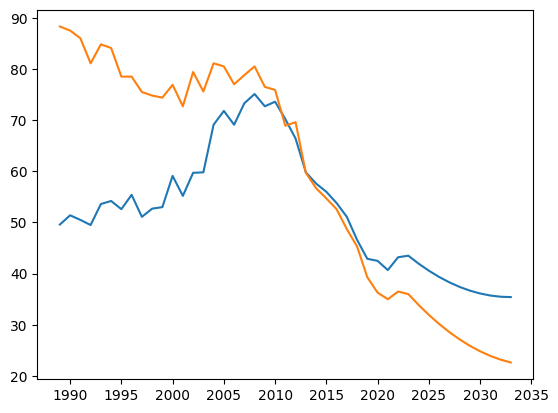

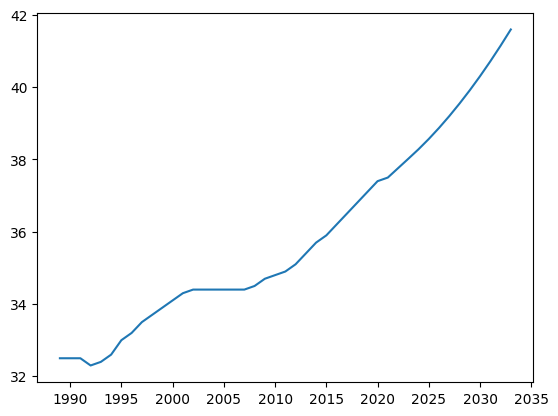

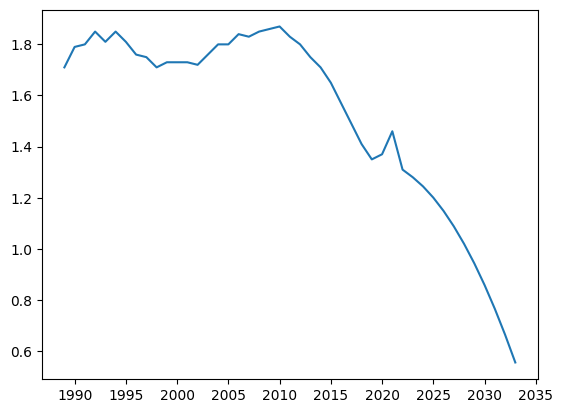

In [48]:
plt.plot(full_ensemble.avioituvuus_30_34)
plt.plot(full_ensemble.avioituvuus_25_29)
plt.show()
plt.plot(full_ensemble.sisempikaupunki)
plt.show()
plt.plot(full_ensemble.tfr)

In [81]:
model_list = [
    #'UnobservedComponents',
    #'GLS',
    #'ARCH',
    #'NeuralProphet',
    #'GLM',
    #'ETS',
    'VECM',
    #'Theta',
    'ARDL',
    #'RollingRegression',
    #'FBProphet',
    'KalmanStateSpace',
    #'WindowRegression',
    #'UnivariateRegression',
    #'PytorchForecasting',
    'LATC',
    #'ConstantNaive',
    #'LastValueNaive',
    #'AverageValueNaive',
#    'VARMAX',
#    'ARIMA'
]


def pred_model(m,df):
    df_forecast = model_forecast(
        model_name=m,
        model_param_dict={}, #'method': 'Mean'},
        model_transform_dict={
            #'fillna': 'mean',
            #'transformations': {'0': 'DifferencedTransformer'},
            #'transformation_params': {'0': {}}
        },
        df_train=df,
        forecast_length=10,
        frequency='infer',
        prediction_interval=0.9,
        no_negatives=False,
        # future_regressor_train=future_regressor_train2d,
        # future_regressor_forecast=future_regressor_forecast2d,
        random_seed=321,
        verbose=0,
        n_jobs="auto",
    )
    fd=df_forecast.forecast.head(10)
    
    return fd

def predict_models(model_list,data,transform=False):
    if transform:
        modata=data.copy().apply(div100).apply(onex2).apply(mul100)
    else:
        modata=data.copy()
    #print(modata)
    cols=list(data.columns)
    #print(cols,type(cols))
    mlist=model_list.copy()
    mlist.extend(['full'])
    print(mlist,model_list)
    ind = pd.MultiIndex.from_product([mlist,cols], names=['models','datasets'])
    full=pd.DataFrame(columns=ind)
    print(full)
    for m in model_list:
        print(m)
        if transform:
            fd=pred_model(m,modata).apply(div100).apply(invonex2).apply(mul100)
        else:
            fd=pred_model(m,modata)
        print(fd)
        full[m]=pd.concat([data,fd])
    print(fd,full_ensemble)
    print(pd.concat([data,fd]).shape,full_ensemble.shape)
    full['full']=full_ensemble
        
    return full

def plot_model(fulldf,dataset='avioituvuus_30_34'):
    mlist=model_list.copy()
    mlist.extend(['full'])
    for m in mlist:
        plt.plot(fulldf[m][dataset],label=m)    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(dataset)
    plt.show()


In [82]:
forecast=predict_models(model_list,data)

['VECM', 'ARDL', 'KalmanStateSpace', 'LATC', 'full'] ['VECM', 'ARDL', 'KalmanStateSpace', 'LATC']
Empty DataFrame
Columns: [(VECM, alypuhelin), (VECM, some_25_34), (VECM, some_35_44), (VECM, avioituvuus_25_29), (VECM, avioituvuus_30_34), (VECM, synnyttajien_keskiika), (VECM, sisempikaupunki), (VECM, ulompikaupunki), (VECM, kehyskaupunki), (VECM, maaseudulla), (VECM, tfr), (ARDL, alypuhelin), (ARDL, some_25_34), (ARDL, some_35_44), (ARDL, avioituvuus_25_29), (ARDL, avioituvuus_30_34), (ARDL, synnyttajien_keskiika), (ARDL, sisempikaupunki), (ARDL, ulompikaupunki), (ARDL, kehyskaupunki), (ARDL, maaseudulla), (ARDL, tfr), (KalmanStateSpace, alypuhelin), (KalmanStateSpace, some_25_34), (KalmanStateSpace, some_35_44), (KalmanStateSpace, avioituvuus_25_29), (KalmanStateSpace, avioituvuus_30_34), (KalmanStateSpace, synnyttajien_keskiika), (KalmanStateSpace, sisempikaupunki), (KalmanStateSpace, ulompikaupunki), (KalmanStateSpace, kehyskaupunki), (KalmanStateSpace, maaseudulla), (KalmanStateSpac

            alypuhelin  some_25_34  some_35_44  avioituvuus_25_29  \
2024-01-01   88.905216   83.013579   78.798412          19.552499   
2025-01-01   89.352248   84.091817   80.144268                NaN   
2026-01-01   89.764543   85.040411   81.327516                NaN   
2027-01-01   90.146012   85.881566   82.376271                NaN   
2028-01-01   90.499996   86.632662   83.312448                NaN   
2029-01-01   90.829370   87.307501   84.153407                NaN   
2030-01-01   91.136620   87.917188   84.913080                NaN   
2031-01-01   91.423907   88.470761   85.602791                NaN   
2032-01-01   91.693120   88.975657   86.231837                NaN   
2033-01-01   91.945915   89.438045   86.807930                NaN   

            avioituvuus_30_34  synnyttajien_keskiika  sisempikaupunki  \
2024-01-01          41.410018              31.936408        38.252022   
2025-01-01          40.111974              32.062585        38.487320   
2026-01-01          3

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


            alypuhelin  some_25_34  some_35_44  avioituvuus_25_29  \
2024-01-01   88.902869   79.899416   76.204692          35.228376   
2025-01-01   89.753872   79.791601   76.392916          34.454456   
2026-01-01   90.552339   79.672835   76.571097          33.667349   
2027-01-01   91.298578   79.630889   76.904274          32.716579   
2028-01-01   91.992604   79.589008   77.233363          31.972132   
2029-01-01   92.636529   79.547348   77.560281          30.839347   
2030-01-01   93.234052   79.504180   77.883436          29.982329   
2031-01-01   93.787948   79.462650   78.205689          28.563295   
2032-01-01   94.304470   79.420995   78.525096          27.029064   
2033-01-01   94.781118   79.380196   78.843053          25.852400   

            avioituvuus_30_34  synnyttajien_keskiika  sisempikaupunki  \
2024-01-01          43.132448              31.915268        38.235237   
2025-01-01          42.738672              32.044982        38.457148   
2026-01-01          4

/Users/anttitanskanen/opt/miniconda3/envs/py311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


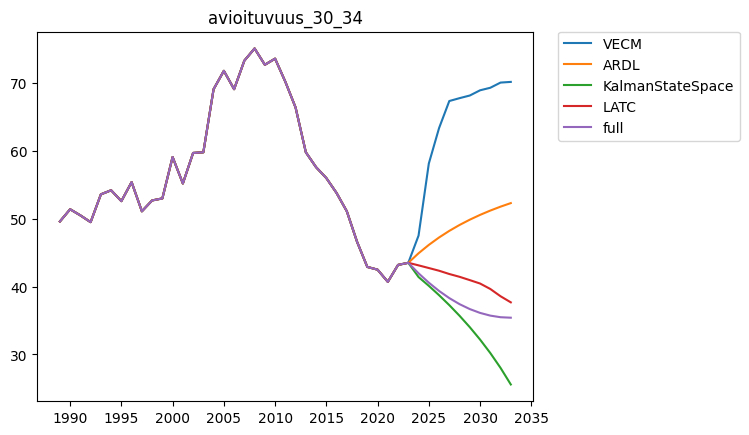

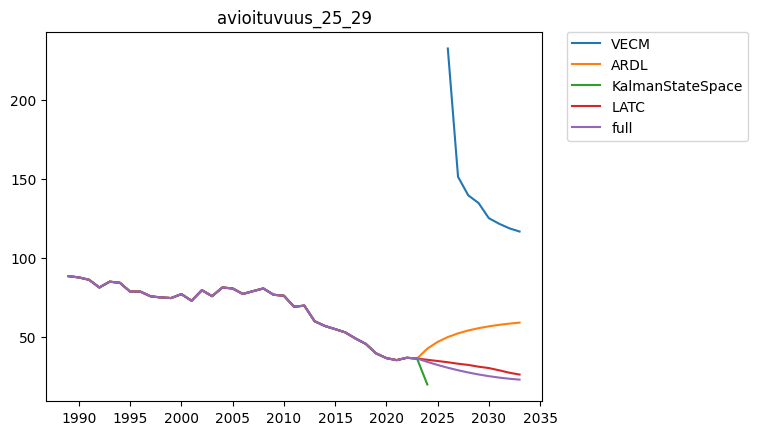

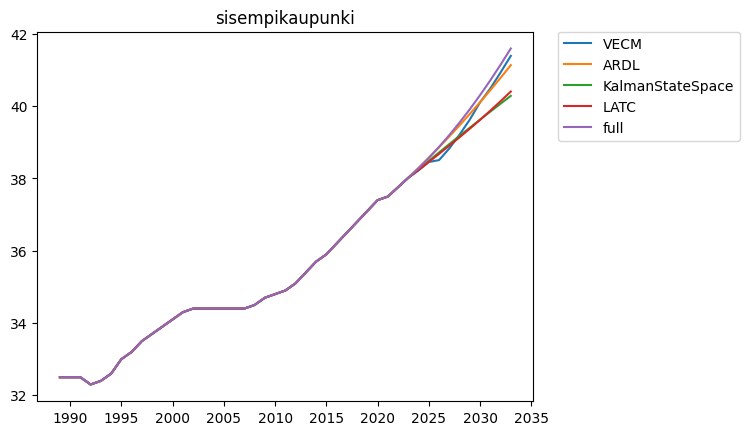

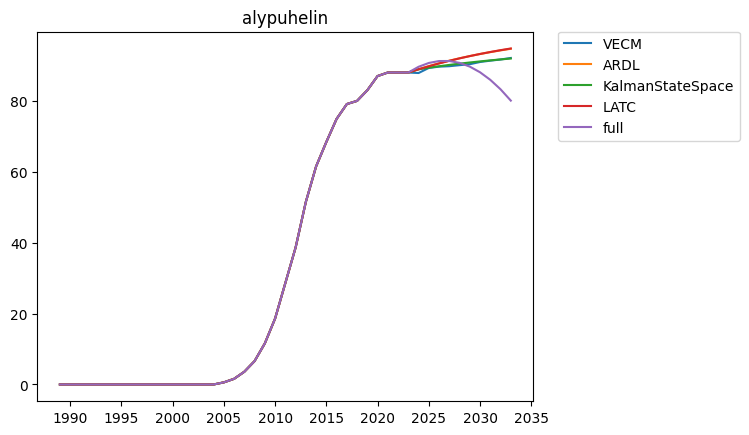

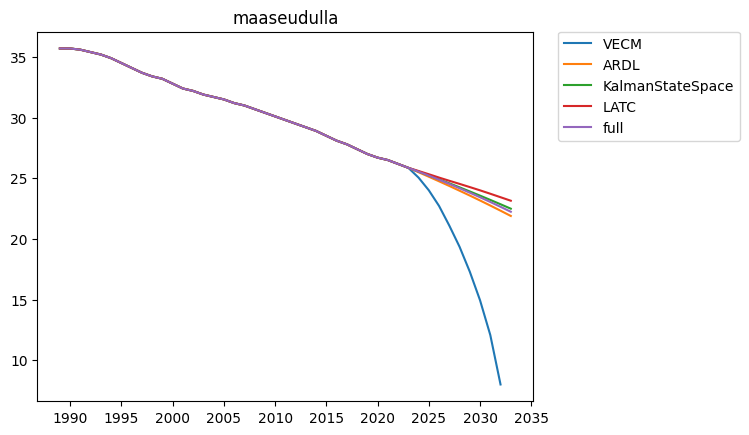

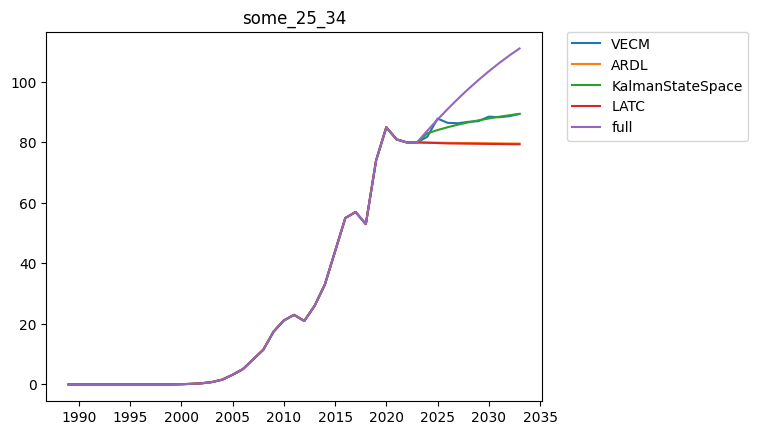

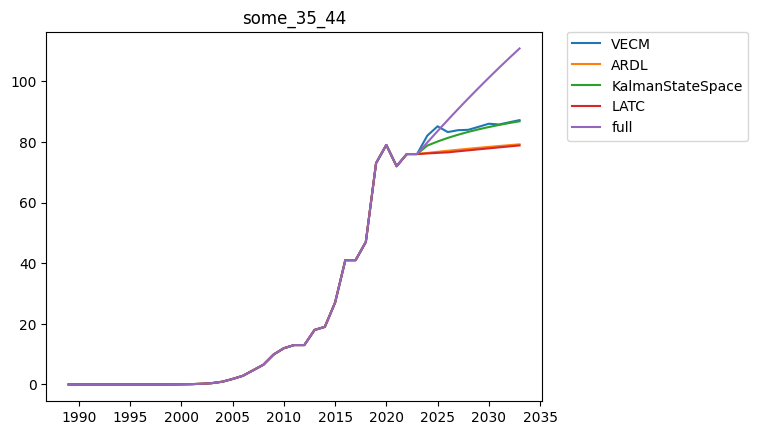

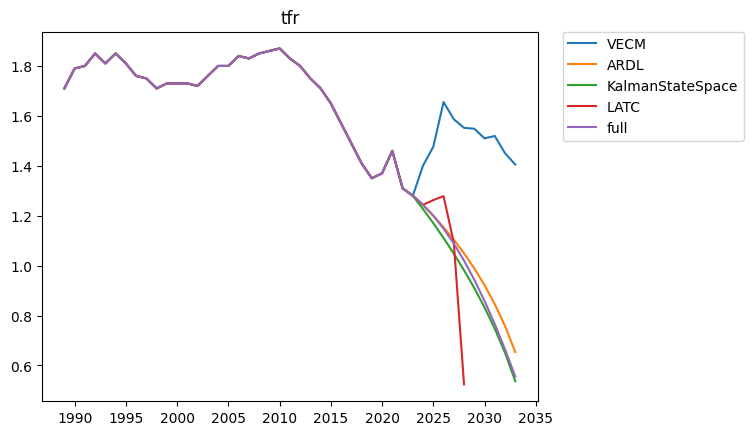

In [83]:
plot_model(forecast,'avioituvuus_30_34')
plot_model(forecast,'avioituvuus_25_29')
plot_model(forecast,'sisempikaupunki')
plot_model(forecast,'alypuhelin')
plot_model(forecast,'maaseudulla')
plot_model(forecast,'some_25_34')
plot_model(forecast,'some_35_44')
plot_model(forecast,'tfr')